# 1. Imports

In [1]:
# import sys
# from google.colab import drive

# drive.mount('/content/gdrive', force_remount=True)
# SRC_PATH = '/content/gdrive/MyDrive/MP FEB/FREDDIEMAC'
# DATA_SRC_PATH = SRC_PATH + "/data"
# sys.path.append(SRC_PATH)

# !pip install wandb -qqq
# import wandb
# wandb.login()

# !pip install dask[dataframe] -qqq
# !pip install fastparquet python-snappy -qqq
# import dask.dataframe as dd



# wandb.init(
#     # Set the project where this run will be logged
#     project="main_FREDDIEMAC", 
#     # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
#     #name="experiment 1"
#     # Track hyperparameters and run metadata
#     #config={
#       #"learning_rate": 0.02,
#       #"architecture": "CNN",
#       #"dataset": "CIFAR-100",
#       #"epochs": 10,}
#     )

In [2]:
DATA_SRC_PATH = "./data"

In [3]:
%load_ext autoreload
%autoreload 2

import dask.dataframe as dd
import os
import numpy as np
import pandas as pd
import torch
import copy

import matplotlib.pyplot as plt
%matplotlib inline

DEVICE = 'cuda'

# 2. Import Dataset

### 2.1 Loading raw data

In [4]:
blumenstock_dynamic_types = {'LOAN_SEQUENCE_NUMBER': str, 'MONTHLY_REPORTING_PERIOD': str,'CURRENT_ACTUAL_UPB': float, 'CURRENT_LOAN_DELINQUENCY_STATUS': float, 
                    'CURRENT_INTEREST_RATE':float,'ELTV': float ,'LOAN_AGE': float, 'REMAINING_MONTHS_TO_LEGAL_MATURITY': float, 'CREDIT_SCORE': float,
                    'DTI': float, 'LTV': float, 'BAL_REPAID': float, 
                    'LABEL': float, "TIME_TO_EVENT": float, 'ORIGINAL_INTEREST_RATE': float, 'ORIGINAL_UPB': float, 'TOTAL_OBSERVED_LENGTH': float}

df_blumenstock_dynamic = dd.read_parquet(DATA_SRC_PATH + "/blumenstock_dynamic_labeled_sample_orig_*.parquet.gzip")
df_blumenstock_dynamic = df_blumenstock_dynamic.astype(blumenstock_dynamic_types)

print("This dataframe contains a total of %d entries" % len(df_blumenstock_dynamic))
print("This dataframe contains a total of %d loands" % len(df_blumenstock_dynamic["LOAN_SEQUENCE_NUMBER"].unique()))

This dataframe contains a total of 5630970 entries
This dataframe contains a total of 83513 loands


### 2.2 Normalising raw data

In [5]:
covariates_to_normalise = ['CURRENT_ACTUAL_UPB', 'CURRENT_LOAN_DELINQUENCY_STATUS', 'CURRENT_INTEREST_RATE', 'ELTV', 'LOAN_AGE', 'REMAINING_MONTHS_TO_LEGAL_MATURITY', 'CREDIT_SCORE',
                            'DTI', 'LTV', 'BAL_REPAID', 'ORIGINAL_INTEREST_RATE', 'ORIGINAL_UPB']

df_blumenstoch_dynamic_mean = df_blumenstock_dynamic[covariates_to_normalise].mean().compute()
df_blumenstoch_std = df_blumenstock_dynamic[covariates_to_normalise].std().compute()

df_blumenstock_dynamic[covariates_to_normalise] = (df_blumenstock_dynamic[covariates_to_normalise] - df_blumenstoch_dynamic_mean) / df_blumenstoch_std

### 2.3 Splitting train, validation and test-set

In [6]:
#TODO THESE SETS ARE OVERLAPPING!!!

AMOUNT_OF_TRAIN_LOANS = 2**14 + 1
AMOUNT_OF_VALIDATE_LOANS = 2**8 + 1
AMOUNT_OF_TEST_LOANS = 2**7 + 1

train_choices = np.random.choice(df_blumenstock_dynamic["LOAN_SEQUENCE_NUMBER"].unique(), AMOUNT_OF_TRAIN_LOANS, replace=False)
validate_choices = np.random.choice(df_blumenstock_dynamic["LOAN_SEQUENCE_NUMBER"].unique(), AMOUNT_OF_VALIDATE_LOANS, replace=False)
test_choices = np.random.choice(df_blumenstock_dynamic["LOAN_SEQUENCE_NUMBER"].unique(), AMOUNT_OF_TEST_LOANS, replace=False)

validate_df_blumenstock = df_blumenstock_dynamic[df_blumenstock_dynamic["LOAN_SEQUENCE_NUMBER"].isin(validate_choices)]
train_df_blumenstock = df_blumenstock_dynamic[df_blumenstock_dynamic["LOAN_SEQUENCE_NUMBER"].isin(train_choices)]
test_df_blumenstock = df_blumenstock_dynamic[df_blumenstock_dynamic["LOAN_SEQUENCE_NUMBER"].isin(test_choices)]

print("Total train set contains %d entries" % len(train_df_blumenstock))
print("Total validation set contains %d entries" % len(validate_df_blumenstock))
print("Total test set contains %d entries" % len(test_df_blumenstock))

print("------------------------------------------------------------------")
print("Total train set contains %d loans" % len(train_df_blumenstock["LOAN_SEQUENCE_NUMBER"].unique()))
print("Total validation set contains %d loans" % len(validate_df_blumenstock["LOAN_SEQUENCE_NUMBER"].unique()))
print("Total test set contains %d loans" % len(test_df_blumenstock["LOAN_SEQUENCE_NUMBER"].unique()))

Total train set contains 1102423 entries
Total validation set contains 17232 entries
Total test set contains 8622 entries
------------------------------------------------------------------
Total train set contains 16385 loans
Total validation set contains 257 loans
Total test set contains 129 loans


### 2.4 Creating dataloaders

In [7]:
from torch.utils.data import DataLoader
from FREDDIEMAC_main_data import FREDDIEMAC_main_dataset, FREDDIEMAC_main_dataloader

BATCH_SIZE = 2**7

allowed_covariates = ['CURRENT_ACTUAL_UPB', 'CURRENT_LOAN_DELINQUENCY_STATUS', 'CURRENT_INTEREST_RATE', 'ELTV', 
                             'LOAN_AGE', 'REMAINING_MONTHS_TO_LEGAL_MATURITY', 'CREDIT_SCORE', 'DTI', 'LTV', 'BAL_REPAID', 
                             'ORIGINAL_INTEREST_RATE', 'ORIGINAL_UPB']

TOTAL_OBSERVED_LENGTH_covariate = 'TOTAL_OBSERVED_LENGTH'
TIME_TO_EVENT_covariate ='TIME_TO_EVENT'
LABEL_covariate = 'LABEL'

random_state = 123
augment = False
data_augment_factor = 3

print("batch_size = ", BATCH_SIZE)
print("number of covariates = ", len(allowed_covariates))

batch_size =  128
number of covariates =  12


#### 2.4.1 Creating train dataloader

In [8]:
augment_train_data = True

train_FREDDIEMAC_raw_dataset = FREDDIEMAC_main_dataset(train_df_blumenstock, 
                                                        allowed_covariates,
                                                        TIME_TO_EVENT_covariate,
                                                        TOTAL_OBSERVED_LENGTH_covariate,
                                                        LABEL_covariate,
                                                        frac_cases=1,
                                                        random_state=random_state,
                                                        test_set=False,
                                                        augment=augment_train_data,
                                                        data_augment_factor=data_augment_factor)

print("This dataset will contain %d samples" % len(train_FREDDIEMAC_raw_dataset))
train_data_loader = FREDDIEMAC_main_dataloader(dataset=train_FREDDIEMAC_raw_dataset, batch_size=BATCH_SIZE)
print("This dataloader will deliver %d batches" % train_data_loader.get_max_iterations())
batch_data, batch_data_length, batch_event, batch_tte = next(train_data_loader)

print(batch_data.shape)
print(batch_data_length.shape)
print(batch_event.shape)
print(batch_tte.shape)

This dataset will contain 65540 samples
This dataloader will deliver 512 batches
torch.Size([128, 180, 12])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


#### 2.4.2 Creating validate dataloader

In [9]:
augment_validate_data = False

validate_FREDDIEMAC_raw_dataset = FREDDIEMAC_main_dataset(validate_df_blumenstock, 
                                                            allowed_covariates,
                                                            TIME_TO_EVENT_covariate,
                                                            TOTAL_OBSERVED_LENGTH_covariate,
                                                            LABEL_covariate,
                                                            frac_cases=1,
                                                            random_state=random_state,
                                                            test_set=False,
                                                            augment=augment_validate_data,
                                                            data_augment_factor=data_augment_factor)

print("This dataset will contain %d samples" % len(validate_FREDDIEMAC_raw_dataset))
validate_data_loader = FREDDIEMAC_main_dataloader(dataset=validate_FREDDIEMAC_raw_dataset, batch_size=BATCH_SIZE)
print("This dataloader will deliver %d batches" % validate_data_loader.get_max_iterations())
batch_data, batch_data_length, batch_event, batch_tte = next(validate_data_loader)

print(batch_data.shape)
print(batch_data_length.shape)
print(batch_event.shape)
print(batch_tte.shape)

This dataset will contain 257 samples
This dataloader will deliver 2 batches
torch.Size([128, 180, 12])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


#### 2.4.3 Creating a test sample

In [10]:
augment_test_data = False

test_FREDDIEMAC_raw_dataset = FREDDIEMAC_main_dataset(test_df_blumenstock, 
                                                    allowed_covariates,
                                                    TIME_TO_EVENT_covariate,
                                                    TOTAL_OBSERVED_LENGTH_covariate,
                                                    LABEL_covariate,
                                                    frac_cases=1,
                                                    random_state=random_state,
                                                    test_set=False,
                                                    augment=augment_test_data,
                                                    data_augment_factor=data_augment_factor)

print("This dataset will contain %d samples" % len(test_FREDDIEMAC_raw_dataset))
test_data_loader = FREDDIEMAC_main_dataloader(dataset=test_FREDDIEMAC_raw_dataset, batch_size=BATCH_SIZE)
print("This dataloader will deliver %d batches" % test_data_loader.get_max_iterations())
batch_data, batch_data_length, batch_event, batch_tte = next(test_data_loader)

print(batch_data.shape)
print(batch_data_length.shape)
print(batch_event.shape)
print(batch_tte.shape)

This dataset will contain 129 samples
This dataloader will deliver 1 batches
torch.Size([128, 180, 12])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


### 2.5 Data Exploration

In [11]:
batch_data, batch_data_length, batch_event, batch_tte = next(iter(train_data_loader))

for i in range(min(BATCH_SIZE, 16)):
    print("batch event= %d --- batch_data_length= %d --- batch_tte= %d" % (batch_event[i], batch_data_length[i], batch_tte[i]))

batch event= 0 --- batch_data_length= 22 --- batch_tte= 22
batch event= 0 --- batch_data_length= 14 --- batch_tte= 30
batch event= 0 --- batch_data_length= 78 --- batch_tte= 117
batch event= 3 --- batch_data_length= 95 --- batch_tte= 95
batch event= 0 --- batch_data_length= 23 --- batch_tte= 23
batch event= 3 --- batch_data_length= 57 --- batch_tte= 57
batch event= 3 --- batch_data_length= 104 --- batch_tte= 104
batch event= 3 --- batch_data_length= 103 --- batch_tte= 103
batch event= 0 --- batch_data_length= 16 --- batch_tte= 29
batch event= 0 --- batch_data_length= 21 --- batch_tte= 21
batch event= 3 --- batch_data_length= 122 --- batch_tte= 122
batch event= 3 --- batch_data_length= 106 --- batch_tte= 106
batch event= 3 --- batch_data_length= 64 --- batch_tte= 64
batch event= 0 --- batch_data_length= 18 --- batch_tte= 18
batch event= 3 --- batch_data_length= 130 --- batch_tte= 130
batch event= 0 --- batch_data_length= 41 --- batch_tte= 66


# 3. Hyperparameters

In [12]:
from torch.optim import Adam

from dynamicDeepHit import EncoderRNN, AttnDecoderRNN, CauseSpecificSubnetwork, DynamicDeepHit
from losses import loss_1_batch, loss_2_batch, loss_3_batch

NUM_EPOCHS = 1

LEARNING_RATE_ENCODER = 0.001
LEARNING_RATE_DECODER = 0.001
LEARNING_RATE_CAUSESS = 0.0005

LOSS_1_AMPLIFIER = 1
LOSS_2_AMPLIFIER = 4
LOSS_3_AMPLIFIER = 10

RUN_VALIDATION_ROUND = True
RUN_VALIDATION_ROUND_BATCHES_THRESHOLD = 2**4
VAL_NUM_CASES_RUNTIME = BATCH_SIZE

input_size = train_FREDDIEMAC_raw_dataset.get_num_covariates()
output_size = input_size
MAX_LENGTH = train_FREDDIEMAC_raw_dataset.get_max_length()

NUM_CAUSES = 3
SIGMA = 0.1

rnn_state_size = 300

encoder_fc_size = 300
attention_fc_size = 300
cause_fc_size = 50*NUM_CAUSES


# 4. Defining The Model

In [13]:
# initialize model
encoder = EncoderRNN(input_size, rnn_state_size, encoder_fc_size, output_size).to(DEVICE)
decoder = AttnDecoderRNN(rnn_state_size, input_size, attention_fc_size).to(DEVICE)
causess = CauseSpecificSubnetwork(rnn_state_size, input_size, cause_fc_size, MAX_LENGTH, NUM_CAUSES).to(DEVICE)
DDHT = DynamicDeepHit(encoder, decoder, causess, MAX_LENGTH, DEVICE)

# intialize optimizer
optimizer_encoder = Adam(encoder.parameters(), lr=LEARNING_RATE_ENCODER, weight_decay=1)
optimizer_decoder = Adam(decoder.parameters(), lr=LEARNING_RATE_DECODER, weight_decay=1)
optimizer_causess = Adam(causess.parameters(), lr=LEARNING_RATE_CAUSESS, weight_decay=1)

### 4.1 Testing a sample before training

For the first sample of the test batch:
sample has length 60
the model predicts the event 0 at time 49
probability of prepay event = 0.34
probability of default event = 0.33
probability of full repay event = 0.33


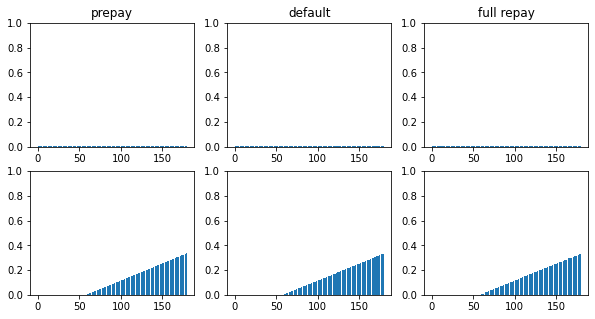

In [14]:
from utils import plot_fht_and_cif, plot_fht, plot_cif
from losses import CIF_K_tau

test_batch_data, test_batch_data_length, test_batch_event, test_batch_tte = next(iter(test_data_loader))

test_batch_data = test_batch_data.to(DEVICE)
test_batch_data_length = test_batch_data_length.to(DEVICE)
test_batch_event = test_batch_event.to(DEVICE)

DDHT.eval()

test_output, test_first_hitting_time, _ = DDHT(test_batch_data, test_batch_data_length)
test_first_hitting_time_argmax = test_first_hitting_time.argmax(dim=1)
model_event_prediction = test_first_hitting_time_argmax // MAX_LENGTH
model_tte_prediction = test_first_hitting_time_argmax % MAX_LENGTH

DDHT.train()

print("For the first sample of the test batch:")
print("sample has length %d" % test_batch_data_length[0])
print("the model predicts the event %d at time %d" % (model_event_prediction[0], model_tte_prediction[0] + 1))

print("probability of prepay event = %.2f" % CIF_K_tau(test_first_hitting_time[0], 0, MAX_LENGTH, test_batch_data_length[0], MAX_LENGTH).item())
print("probability of default event = %.2f" % CIF_K_tau(test_first_hitting_time[0], 1, MAX_LENGTH, test_batch_data_length[0], MAX_LENGTH).item())
print("probability of full repay event = %.2f" % CIF_K_tau(test_first_hitting_time[0], 2, MAX_LENGTH, test_batch_data_length[0], MAX_LENGTH).item())

plot_fht_and_cif(test_first_hitting_time[0], test_batch_data_length[0], MAX_LENGTH)

# 5. Training the model

In [15]:
# PATH = "models/main_model_local_v3.pth"

# # start training
# for epoch in range(NUM_EPOCHS):

#   epoch_loss = 0
#   train_epoch_val_loss = 0
#   train_epoch_val_loss1 = 0
#   train_epoch_val_loss2 = 0

#   for batch_number in range(len(train_data_loader)):
#     data = next(train_data_loader)

#     batch_loss = 0

#     optimizer_encoder.zero_grad()
#     optimizer_decoder.zero_grad()
#     optimizer_causess.zero_grad()

#     batch_data, batch_data_length, batch_event, batch_tte = data
#     batch_data = batch_data.to(DEVICE)
#     batch_data_length = batch_data_length.to(DEVICE)
#     batch_event = batch_event.to(DEVICE)
#     batch_tte = batch_tte.to(DEVICE)
    
#     output_batch, first_hitting_time_batch, _ = DDHT(batch_data, batch_data_length)

#     loss1 = LOSS_1_AMPLIFIER*loss_1_batch(first_hitting_time_batch, batch_event, batch_tte, batch_data_length, MAX_LENGTH, DEVICE)
#     loss2 = LOSS_2_AMPLIFIER*loss_2_batch(first_hitting_time_batch, batch_event, batch_tte, batch_data_length, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)
#     loss3 = LOSS_3_AMPLIFIER*loss_3_batch(output_batch, batch_data.detach())

#     batch_loss = loss1 + loss2 + loss3
#     batch_loss.backward()

#     epoch_loss += batch_loss.detach()

#     #wandb.log({"train_loss1": loss1.item(), "train_loss2": loss2.item(), "train_loss3": loss3.item()})
#     print({"train_loss1": loss1.item(), "train_loss2": loss2.item(), "train_loss3": loss3.item()})

#     optimizer_encoder.step()
#     optimizer_decoder.step()
#     optimizer_causess.step()

#     if RUN_VALIDATION_ROUND and batch_number % 5 == 0:
#       # validation round
#       INTERMEDIATE_PATH = f"models/main_model_local_{batch_number}_v3.pth"
#       torch.save(DDHT.state_dict(), INTERMEDIATE_PATH)
#       DDHT.eval()

#       val_epoch_val_loss = 0
#       val_epoch_val_loss1 = 0
#       val_epoch_val_loss2 = 0
#       val_epoch_val_loss3 = 0

#       VAL_NUM_CASES_RUNTIME = len(validate_data_loader)*BATCH_SIZE
#       for validation_batch_number in range(len(validate_data_loader)):
#         data = next(validate_data_loader)

#         with torch.no_grad():
#           val_batch_data, val_batch_data_length, val_batch_event, val_batch_tte = next(iter(validate_data_loader))
#           val_batch_data = val_batch_data.to(DEVICE)
#           val_batch_data_length = val_batch_data_length.to(DEVICE)
#           val_batch_event = val_batch_event.to(DEVICE)
#           val_batch_tte = val_batch_tte.to(DEVICE)

#           val_output_batch, val_first_hitting_time_batch, _ = DDHT(val_batch_data, val_batch_data_length)

#           val_loss1 = LOSS_1_AMPLIFIER*loss_1_batch(val_first_hitting_time_batch, val_batch_event, val_batch_tte, val_batch_data_length, MAX_LENGTH, DEVICE)/VAL_NUM_CASES_RUNTIME
#           val_loss2 = LOSS_2_AMPLIFIER*loss_2_batch(val_first_hitting_time_batch, val_batch_event, val_batch_tte, val_batch_data_length, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)/VAL_NUM_CASES_RUNTIME
#           val_loss3 = LOSS_3_AMPLIFIER*loss_3_batch(val_output_batch, val_batch_data.detach())/VAL_NUM_CASES_RUNTIME

#           val_epoch_val_loss1 += val_loss1
#           val_epoch_val_loss2 += val_loss2
#           val_epoch_val_loss3 += val_loss3
#           val_epoch_val_loss = val_loss1 + val_loss2 + val_loss3

#       #wandb.log({"val_epoch_val_loss1": val_epoch_val_loss1.item(), "val_epoch_val_loss2": val_epoch_val_loss2.item(), "val_epoch_val_loss3": val_epoch_val_loss3.item(), "val_epoch_val_loss": val_epoch_val_loss.item()})
#       print({"val_epoch_val_loss1": val_epoch_val_loss1.item(), "val_epoch_val_loss2": val_epoch_val_loss2.item(), "val_epoch_val_loss3": val_epoch_val_loss3.item()})

#       DDHT.train()
#       # end validating round

#   #wandb.log({"train_epoch_loss": epoch_loss.item()})
#   torch.save(DDHT.state_dict(), PATH)

# #wandb.finish() 

In [16]:
batch_tte.max()

tensor(139)

# 6. Testing the models performance

In [17]:
#PATH = "/content/gdrive/MyDrive/MP FEB/FREDDIEMAC/models/main_model_v1.pth"
PATH = "models/main_model_v2_464.pth"
#torch.save(DDHT.state_dict(), PATH)
DDHT.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [59]:
test_sample_index = 0

### 6.1 Testing a sample after training

For the first sample of the test batch:
sample has length 60
the model predicts the event 0 at time 13
probability of prepay event = 0.62
probability of default event = 0.22
probability of full repay event = 0.16


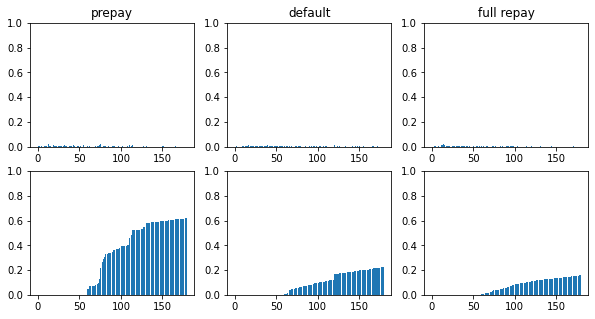

In [19]:
from utils import plot_fht_and_cif, plot_fht, plot_cif
from losses import CIF_K_tau

test_batch_data, test_batch_data_length, test_batch_event, test_batch_tte = next(iter(test_data_loader))

test_batch_data = test_batch_data.to(DEVICE)
test_batch_data_length = test_batch_data_length.to(DEVICE)
test_batch_event = test_batch_event.to(DEVICE)

DDHT.eval()

test_output, test_first_hitting_time, test_attention_weights = DDHT(test_batch_data, test_batch_data_length)
test_first_hitting_time_argmax = test_first_hitting_time.argmax(dim=1)
model_event_prediction = test_first_hitting_time_argmax // MAX_LENGTH
model_tte_prediction = test_first_hitting_time_argmax % MAX_LENGTH

print("For the first sample of the test batch:")
print("sample has length %d" % test_batch_data_length[test_sample_index])
print("the model predicts the event %d at time %d" % (model_event_prediction[test_sample_index], model_tte_prediction[test_sample_index] + 1))

print("probability of prepay event = %.2f" % CIF_K_tau(test_first_hitting_time[test_sample_index], 0, MAX_LENGTH, test_batch_data_length[test_sample_index], MAX_LENGTH).item())
print("probability of default event = %.2f" % CIF_K_tau(test_first_hitting_time[test_sample_index], 1, MAX_LENGTH, test_batch_data_length[test_sample_index], MAX_LENGTH).item())
print("probability of full repay event = %.2f" % CIF_K_tau(test_first_hitting_time[test_sample_index], 2, MAX_LENGTH, test_batch_data_length[test_sample_index], MAX_LENGTH).item())

plot_fht_and_cif(test_first_hitting_time[test_sample_index], test_batch_data_length[test_sample_index], MAX_LENGTH)

### 6.2 Testing more samples

In [20]:
for test_sample_index in range(2**3):
  print("--------------------------------------------")
  print("sample will experiece event: %d - at time %d" % (test_batch_event[test_sample_index], test_batch_data_length[test_sample_index]))
  print("model will predict event:    %d - at time %d" % (model_event_prediction[test_sample_index], model_tte_prediction[test_sample_index]))

--------------------------------------------
sample will experiece event: 0 - at time 60
model will predict event:    0 - at time 12
--------------------------------------------
sample will experiece event: 0 - at time 30
model will predict event:    0 - at time 12
--------------------------------------------
sample will experiece event: 3 - at time 138
model will predict event:    0 - at time 24
--------------------------------------------
sample will experiece event: 3 - at time 120
model will predict event:    0 - at time 13
--------------------------------------------
sample will experiece event: 0 - at time 126
model will predict event:    0 - at time 44
--------------------------------------------
sample will experiece event: 3 - at time 79
model will predict event:    0 - at time 13
--------------------------------------------
sample will experiece event: 3 - at time 69
model will predict event:    0 - at time 15
--------------------------------------------
sample will experiece

### 6.3 Plotting a confusion matrix

[0.97222222 0.         0.        ]


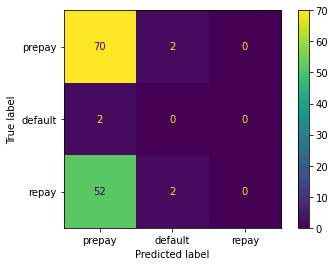

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

a = test_batch_event.flatten().cpu()
b = model_event_prediction.cpu()

cm = confusion_matrix(a, b)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['prepay', 'default', 'repay'])
accuracy = cm.diagonal()/cm.sum(axis=1)

print(accuracy)

disp.plot()
plt.show()

# 7. Analysing the model 

### 7.1 Which attention weights are the most important?

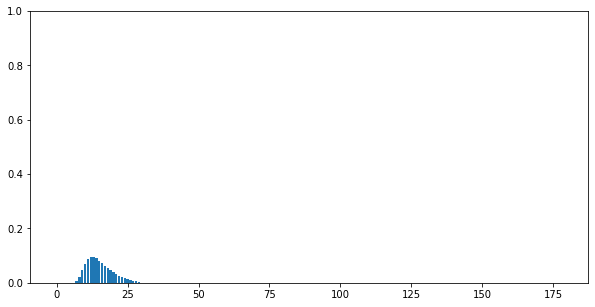

In [22]:
from utils import plot_attention_weights
plot_attention_weights(test_attention_weights[test_sample_index])

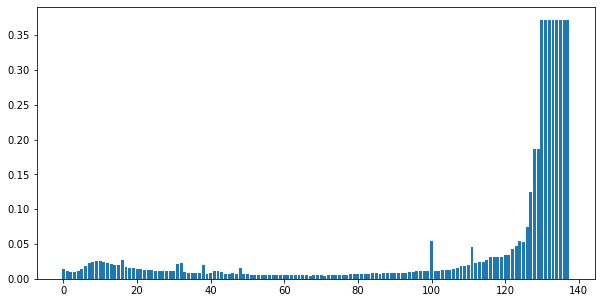

In [23]:
from utils import plot_attention_weights_batch

plot_attention_weights_batch(test_attention_weights, test_batch_data_length, normalised=True, y_lim=None)

### 7.2 What does the model do when we mask some covariates

from the allowed covariates:  ['CURRENT_ACTUAL_UPB', 'CURRENT_LOAN_DELINQUENCY_STATUS', 'CURRENT_INTEREST_RATE', 'ELTV', 'LOAN_AGE', 'REMAINING_MONTHS_TO_LEGAL_MATURITY', 'CREDIT_SCORE', 'DTI', 'LTV', 'BAL_REPAID', 'ORIGINAL_INTEREST_RATE', 'ORIGINAL_UPB']
we masked the following covariates:  ['LOAN_AGE', 'REMAINING_MONTHS_TO_LEGAL_MATURITY']
For the first sample of the test batch:
sample has length 31
the model predicts the event 0 at time 14
probability of prepay event = 0.89
probability of default event = 0.11
probability of full repay event = 0.00


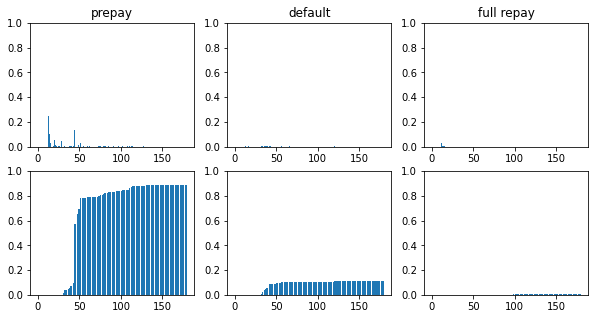

In [24]:
test_batch_data, test_batch_data_length, test_batch_event, test_batch_tte = next(iter(test_data_loader))

test_batch_data = test_batch_data.to(DEVICE)
test_batch_data_length = test_batch_data_length.to(DEVICE)
test_batch_event = test_batch_event.to(DEVICE)

masked_data = copy.deepcopy(test_batch_data)
masked_covariates = ['LOAN_AGE', 'REMAINING_MONTHS_TO_LEGAL_MATURITY']

for covariate in masked_covariates:
  masked_data[:,:,allowed_covariates.index(covariate)] = 0.0

masked_data = masked_data.to(DEVICE)

test_output, test_first_hitting_time, test_attention_weights = DDHT(masked_data, test_batch_data_length)
test_first_hitting_time_argmax = test_first_hitting_time.argmax(dim=1)
model_event_prediction = test_first_hitting_time_argmax // MAX_LENGTH
model_tte_prediction = test_first_hitting_time_argmax % MAX_LENGTH


print("from the allowed covariates: ", allowed_covariates)
print("we masked the following covariates: ", masked_covariates)

print("For the first sample of the test batch:")
print("sample has length %d" % test_batch_data_length[test_sample_index])
print("the model predicts the event %d at time %d" % (model_event_prediction[test_sample_index], model_tte_prediction[test_sample_index] + 1))

print("probability of prepay event = %.2f" % CIF_K_tau(test_first_hitting_time[test_sample_index], 0, MAX_LENGTH, test_batch_data_length[test_sample_index], MAX_LENGTH).item())
print("probability of default event = %.2f" % CIF_K_tau(test_first_hitting_time[test_sample_index], 1, MAX_LENGTH, test_batch_data_length[test_sample_index], MAX_LENGTH).item())
print("probability of full repay event = %.2f" % CIF_K_tau(test_first_hitting_time[test_sample_index], 2, MAX_LENGTH, test_batch_data_length[test_sample_index], MAX_LENGTH).item())

plot_fht_and_cif(test_first_hitting_time[test_sample_index], test_batch_data_length[test_sample_index], MAX_LENGTH)

### 7.3 Probability that this loan will prepay, default or repay in the comming "delta" months?

In [60]:
delta = 6  #This is variable

evaluation_time = min(int(test_batch_data_length[test_sample_index].item()) + delta, MAX_LENGTH)
print("In the comming %d months, the probability that a specific event happens is:" % delta)

p_ev0 = CIF_K_tau(test_first_hitting_time[test_sample_index], 0, evaluation_time, test_batch_data_length[test_sample_index], MAX_LENGTH).item()
p_ev1 = CIF_K_tau(test_first_hitting_time[test_sample_index], 1, evaluation_time, test_batch_data_length[test_sample_index], MAX_LENGTH).item()
p_ev2 = CIF_K_tau(test_first_hitting_time[test_sample_index], 2, evaluation_time, test_batch_data_length[test_sample_index], MAX_LENGTH).item()

print("probability a prepay happens = %.3f" % p_ev0)
print("probability a default happens = %.3f" % p_ev1)
print("probability a full repay happens = %.3f" % p_ev2)

sum = p_ev0 + p_ev1 + p_ev2
print("The probability anything happens = %.3f" % sum)


In the comming 6 months, the probability that a specific event happens is:
probability a prepay happens = 0.076
probability a default happens = 0.020
probability a full repay happens = 0.012
The probability anything happens = 0.108


### 7.4 Probability that this loan will prepay, default or repay with less data

sample has length 60, but we concatenated to 54
For the first sample of the test batch:
sample has length 54
the model predicts the event 0 at time 13
probability of prepay event = 0.59
probability of default event = 0.25
probability of full repay event = 0.16


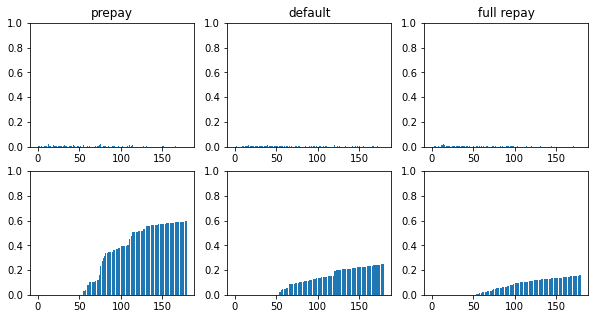

In [67]:
test_batch_data, test_batch_data_length, test_batch_event, test_batch_tte = next(iter(test_data_loader))

delta = 6

shortened_batch_data_length = test_batch_data_length - delta

shortened_batch_data_length = shortened_batch_data_length.to(DEVICE)
test_batch_data = test_batch_data.to(DEVICE)

print("sample has length %d, but we concatenated to %d" % (test_batch_data_length[test_sample_index], shortened_batch_data_length[test_sample_index]))

test_output, test_first_hitting_time, test_attention_weights = DDHT(test_batch_data, shortened_batch_data_length)
test_first_hitting_time_argmax = test_first_hitting_time.argmax(dim=1)
model_event_prediction = test_first_hitting_time_argmax // MAX_LENGTH
model_tte_prediction = test_first_hitting_time_argmax % MAX_LENGTH

print("sample has length %d" % shortened_batch_data_length[test_sample_index])
print("the model predicts the event %d at time %d" % (model_event_prediction[test_sample_index], model_tte_prediction[test_sample_index] + 1))

print("probability of prepay event = %.2f" % CIF_K_tau(test_first_hitting_time[test_sample_index], 0, MAX_LENGTH, shortened_batch_data_length[test_sample_index], MAX_LENGTH).item())
print("probability of default event = %.2f" % CIF_K_tau(test_first_hitting_time[test_sample_index], 1, MAX_LENGTH, shortened_batch_data_length[test_sample_index], MAX_LENGTH).item())
print("probability of full repay event = %.2f" % CIF_K_tau(test_first_hitting_time[test_sample_index], 2, MAX_LENGTH, shortened_batch_data_length[test_sample_index], MAX_LENGTH).item())

plot_fht_and_cif(test_first_hitting_time[test_sample_index], shortened_batch_data_length[test_sample_index], MAX_LENGTH)

the original sample has length 132


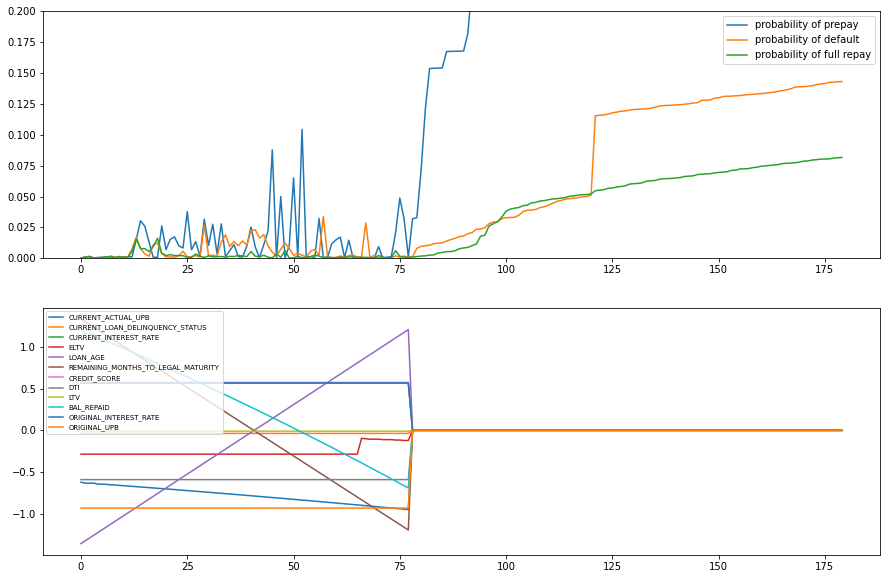

In [109]:
test_sample_index = 2

PREDICTION_DEPTH = 6

from utils import plot_dynamic_risk_prediction

#covariates_to_plot = ["CURRENT_INTEREST_RATE", "CURRENT_LOAN_DELINQUENCY_STATUS", "LOAN_AGE"]
covariates_to_plot = allowed_covariates

probability_of_event_0 = []
probability_of_event_1 = []
probability_of_event_2 = []
covariate_series = []

test_batch_data, test_batch_data_length, test_batch_event, test_batch_tte = next(iter(train_data_loader))

original_test_batch_data = copy.deepcopy(test_batch_data)[test_sample_index].unsqueeze(0).to(DEVICE)
original_length = copy.deepcopy(test_batch_data_length)[test_sample_index].unsqueeze(0).to(DEVICE)

for covariate in covariates_to_plot:
    covariate_series.append(test_batch_data[test_sample_index,:,allowed_covariates.index(covariate)].detach().cpu().numpy())

original_length_integer = original_length.squeeze(0).item()
for evaluation_time in range(original_length_integer):

    delta = original_length_integer - evaluation_time
    shortened_length = original_length - delta
    
    test_output, test_first_hitting_time, _ = DDHT(original_test_batch_data, shortened_length)
    test_first_hitting_time_argmax = test_first_hitting_time.argmax(dim=1)
    model_event_prediction = test_first_hitting_time_argmax // MAX_LENGTH
    model_tte_prediction = test_first_hitting_time_argmax % MAX_LENGTH

    probability_of_event_0.append(CIF_K_tau(test_first_hitting_time[0], 0, evaluation_time + PREDICTION_DEPTH, shortened_length[0], MAX_LENGTH).item())
    probability_of_event_1.append(CIF_K_tau(test_first_hitting_time[0], 1, evaluation_time + PREDICTION_DEPTH, shortened_length[0], MAX_LENGTH).item())
    probability_of_event_2.append(CIF_K_tau(test_first_hitting_time[0], 2, evaluation_time + PREDICTION_DEPTH, shortened_length[0], MAX_LENGTH).item())

test_output, test_first_hitting_time, _ = DDHT(original_test_batch_data, original_length)
test_first_hitting_time_argmax = test_first_hitting_time.argmax(dim=1)
model_event_prediction = test_first_hitting_time_argmax // MAX_LENGTH
model_tte_prediction = test_first_hitting_time_argmax % MAX_LENGTH

for evaluation_time in range(original_length_integer, MAX_LENGTH):
    probability_of_event_0.append(CIF_K_tau(test_first_hitting_time[0], 0, evaluation_time, original_length[0], MAX_LENGTH).item())
    probability_of_event_1.append(CIF_K_tau(test_first_hitting_time[0], 1, evaluation_time, original_length[0], MAX_LENGTH).item())
    probability_of_event_2.append(CIF_K_tau(test_first_hitting_time[0], 2, evaluation_time, original_length[0], MAX_LENGTH).item())

print("the original sample has length %d" % shortened_batch_data_length[test_sample_index])

PLOT_LENGTH = MAX_LENGTH
DATA_LENGTH = original_length_integer
plot_dynamic_risk_prediction(probability_of_event_0, probability_of_event_1, probability_of_event_2, covariates_to_plot, covariate_series, DATA_LENGTH, PLOT_LENGTH, MAX_LENGTH)

### 7.5 Sensitivity to certain covariates

The following covariate sensitivities are represented:
Index 0 represents covariate CURRENT_ACTUAL_UPB
Index 1 represents covariate CURRENT_LOAN_DELINQUENCY_STATUS
Index 2 represents covariate CURRENT_INTEREST_RATE
Index 3 represents covariate ELTV
Index 4 represents covariate LOAN_AGE
Index 5 represents covariate REMAINING_MONTHS_TO_LEGAL_MATURITY
Index 6 represents covariate CREDIT_SCORE
Index 7 represents covariate DTI
Index 8 represents covariate LTV
Index 9 represents covariate BAL_REPAID
Index 10 represents covariate ORIGINAL_INTEREST_RATE
Index 11 represents covariate ORIGINAL_UPB


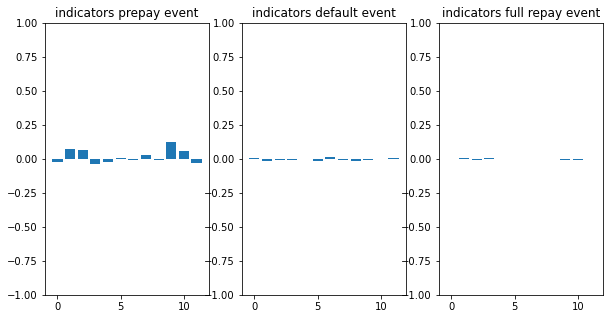

In [27]:
from utils import plot_gamma

delta = 6 #This is variable

min_gamma = torch.zeros(NUM_CAUSES, input_size)
max_gamma = torch.zeros(NUM_CAUSES, input_size)

for covariate_index in range(input_size):
    sensitivity_batch_data, sensitivity_batch_data_length, sensitivity_batch_event, sensitivity_batch_tte = next(iter(test_data_loader))

    #assuming it's minimum & maximum from the whole batch, not from a single sample
    batch_min = torch.tensor(float('Inf'))
    batch_max = (-1)*torch.tensor(float('Inf'))

    #we have to iterate over it otherwise, we catch the zero's that are meant as NANs in our case
    for sample, data_length in zip(sensitivity_batch_data, sensitivity_batch_data_length):
        sample_min = torch.min(sample[:data_length,covariate_index])
        sample_max = torch.max(sample[:data_length,covariate_index])

        if sample_min < batch_min:
            batch_min = sample_min

        if sample_max > batch_max:
            batch_max = sample_max

    min_sensitivity_batch_data = copy.deepcopy(sensitivity_batch_data)
    max_sensitivity_batch_data = copy.deepcopy(sensitivity_batch_data)

    #for safety we iterate again, since we otherwise fill in the zero's that are meant as NANs
    for sample_index, data_length in enumerate(sensitivity_batch_data_length):
        min_sensitivity_batch_data[sample_index,:data_length, covariate_index] = batch_min
        max_sensitivity_batch_data[sample_index,:data_length, covariate_index] = batch_max

    min_sensitivity_batch_data = min_sensitivity_batch_data.to(DEVICE)
    max_sensitivity_batch_data = max_sensitivity_batch_data.to(DEVICE)
    sensitivity_batch_data_length = sensitivity_batch_data_length.to(DEVICE)

    #for safety we iterate again, because the previous iteration might be absorbed by the one above that
    for sample_index, data_length in enumerate(sensitivity_batch_data_length):
        for cause_index in range(NUM_CAUSES):
            evaluation_time = min(int(data_length.item()) + delta, MAX_LENGTH)

            _, max_fht, _ = DDHT(max_sensitivity_batch_data[sample_index].unsqueeze(0), data_length)
            _, min_fht, _ = DDHT(min_sensitivity_batch_data[sample_index].unsqueeze(0), data_length)

            max_gamma[cause_index, covariate_index] += CIF_K_tau(max_fht[0], cause_index, evaluation_time, data_length, MAX_LENGTH).item()
            min_gamma[cause_index, covariate_index] += CIF_K_tau(min_fht[0], cause_index, evaluation_time, data_length, MAX_LENGTH).item()


gamma = (1/BATCH_SIZE)*(min_gamma - max_gamma)

The following covariate sensitivities are represented:
Index 0 represents covariate CURRENT_ACTUAL_UPB
Index 1 represents covariate CURRENT_LOAN_DELINQUENCY_STATUS
Index 2 represents covariate CURRENT_INTEREST_RATE
Index 3 represents covariate ELTV
Index 4 represents covariate LOAN_AGE
Index 5 represents covariate REMAINING_MONTHS_TO_LEGAL_MATURITY
Index 6 represents covariate CREDIT_SCORE
Index 7 represents covariate DTI
Index 8 represents covariate LTV
Index 9 represents covariate BAL_REPAID
Index 10 represents covariate ORIGINAL_INTEREST_RATE
Index 11 represents covariate ORIGINAL_UPB


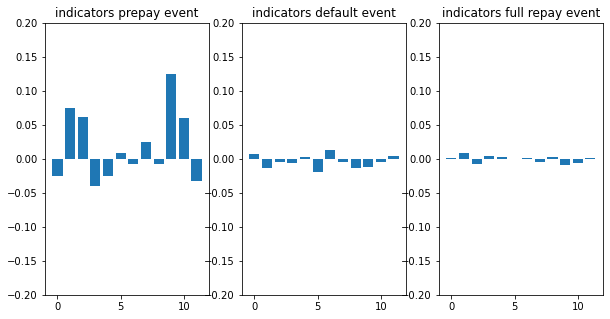

In [29]:
plot_gamma(gamma, y_lim=[-0.2, 0.2])

print("The following covariate sensitivities are represented:")
for i, covariate in enumerate(allowed_covariates):
    print("Index %d represents covariate %s" % (i, covariate))